# Geospatial Image Analysis: Setup

This is a preliminary notebook in which I perform several pre-processings and explorations to start working in the co-located notebook [`Geospatial_Image_Analysis.ipynb`](Geospatial_Image_Analysis.ipynb).

Performed tasks:

- Create GeoJSONs of the lake points.
- Explore the satellite image bands.

### Create GeoJSONs of the Lake Points

In [1]:
import sys
import os
from glob import glob
import numpy as np

from shapely.geometry import Point
from shapely.geometry import box
from shapely.geometry import shape
import geopandas as gpd
import rasterio as rio
import earthpy.plot as ep

import matplotlib.pyplot as plt
import contextily

# Appending aux paths
sys.path.append('../utils')
from resample_raster import resample_res, resample_scale

In [2]:
# Lake coordinates:
# Ammersee: 47.99, 11.12
# Starnbergersee: 47.91, 11.31
# Chiemsee: 47.88, 12.46

# Scene 1
# POLYGON((10.9448829067118 47.73548843800481,
#          11.393297391882829 47.73548843800481,
#          11.393297391882829 48.143490914959585,
#          10.9448829067118 48.143490914959585,
#          10.9448829067118 47.73548843800481))

# Scene 2
# POLYGON((12.276740855204856 47.76998650888808,
#          12.830008478699462 47.76998650888808,
#          12.830008478699462 48.06602436853697,
#          12.276740855204856 48.06602436853697,
#          12.276740855204856 47.76998650888808))

In [3]:
# These paths should contain the contents of the original challenge.
DATA_PATH = "../data/"
SCENE_1_PATH = DATA_PATH + "scene_1"
SCENE_2_PATH = DATA_PATH + "scene_2"

In [4]:
# lng/lat format in EPSG:4326
SCENE_1_BBOX = [10.9448829067118, 47.73548843800481, 11.393297391882829, 48.143490914959585]
SCENE_2_BBOX = [12.276740855204856, 47.76998650888808, 12.830008478699462, 48.06602436853697]

In [24]:
# Choose the scene
#SCENE = 1
SCENE = 2

In [25]:
SCENE_PATH = SCENE_1_PATH
SCENE_BBOX = SCENE_1_BBOX
if SCENE == 2:
    SCENE_PATH = SCENE_2_PATH
    SCENE_BBOX = SCENE_2_BBOX

In [26]:
# Create a GeoSeries with the ROI
bbox = box(minx=SCENE_BBOX[0], miny=SCENE_BBOX[1], maxx=SCENE_BBOX[2], maxy=SCENE_BBOX[3], ccw=True)
gdf_bbox = gpd.GeoSeries([bbox], crs = 'epsg:4326')

In [27]:
# Create a GeoSeries with lake points
# Ammersee: 47.99, 11.12
# Starnbergersee: 47.91, 11.31
# Chiemsee: 47.88, 12.46
lake_point_1 = Point(11.12, 47.99) # Ammersee: 47.992011, 11.127501
lake_point_2 = Point(11.31, 47.91) # Starnbergersee: 47.895558, 11.309792
lake_point_3 = Point(12.46, 47.88) # Chiemsee: 47.878565, 12.469733
gdf_lakes = gpd.GeoSeries([lake_point_1, lake_point_2, lake_point_3], crs = 'epsg:4326')

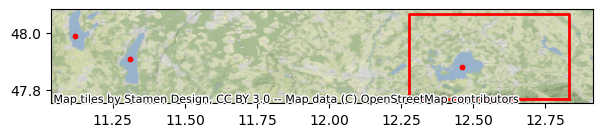

In [28]:
# Plot ROI and all lake points
fig, ax = plt.subplots(figsize=(7, 7))
gdf_lakes.plot(ax=ax, markersize=10, color='red')
ax.plot(*gdf_bbox[0].exterior.xy, color='red', linewidth=2)
contextily.add_basemap(ax, crs=gdf_bbox.crs)
#plt.show()
plt.savefig(f'../assets/scene_{SCENE}_points_ROI.png',dpi=100,transparent=False,bbox_inches='tight')

In [81]:
# Save lake points
gdf_lakes_1 = gpd.GeoSeries([lake_point_1, lake_point_2], crs = 'epsg:4326')
gdf_lakes_2 = gpd.GeoSeries([lake_point_3], crs = 'epsg:4326')
gdf_lakes_1 = gpd.GeoDataFrame(gdf_lakes_1)
gdf_lakes_1.columns = ['geometry']
gdf_lakes_2 = gpd.GeoDataFrame(gdf_lakes_2)
gdf_lakes_2.columns = ['geometry']

In [82]:
gdf_lakes_1['id'] = ['A', 'B']
gdf_lakes_1['name'] = ['Ammersee', 'Starnbergersee']
gdf_lakes_2['id'] = ['C']
gdf_lakes_2['name'] = ['Chiemsee']

In [85]:
gdf_lakes_1.head()

,geometry,id,name
0,POINT (11.12000 47.99000),A,Ammersee
1,POINT (11.31000 47.91000),B,Starnbergersee


In [86]:
gdf_lakes_2.head()

,geometry,id,name
0,POINT (12.46000 47.88000),C,Chiemsee


In [84]:
gdf_lakes_1.to_file("../data/scene_1/lakes.geojson", driver='GeoJSON')
gdf_lakes_2.to_file("../data/scene_2/lakes.geojson", driver='GeoJSON')

### Explore Satellite Image Bands

In [31]:
# Load band filenames
sentinel_bands = glob(SCENE_PATH+"/*B?*.jp2")

In [32]:
# Load points of interest (GeoJSON)
gdf_points = gpd.read_file(SCENE_PATH+'/lakes.geojson')

In [33]:
gdf_points.head()

,geometry
0,POINT (12.46000 47.88000)


In [34]:
print(gdf_points.crs)

epsg:4326


In [35]:
sentinel_bands.sort()
sentinel_bands

['../data/scene_2/T32UQU_20230207T101109_B01_20m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B02_10m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B03_10m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B04_10m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B05_20m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B06_20m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B07_20m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B08_10m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B09_60m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B11_20m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B12_20m.jp2',
 '../data/scene_2/T32UQU_20230207T101109_B8A_20m.jp2']

In [36]:
# Extract band names
# FIXME: Improve with regex...
#band_names = [band.split(os.sep)[-1][1:3] for band in sentinel_bands]
band_names = [band.split(os.sep)[-1][-10:-8] for band in sentinel_bands]
band_names

['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '8A']

In [37]:
# Open one band and get CRS
src = rio.open(sentinel_bands[1])

In [38]:
print(src.crs)

EPSG:32632


In [39]:
# Open band rasters with rasterio
# Resample/Resize if needed: I would take the minimum resolution (60m)
images = []
xres = 60
yres = 60
resample = True
for i in sentinel_bands:
    with rio.open(i, 'r') as src:
        img = None
        profile = None
        if resample:
            img, profile = resample_res(src, xres, yres)
        else:
            img, profile = src.read(1), src.profile
        images.append(img)
        # Display
        print(f"New shape: {img.shape}, org. resolution: {src.res}")

New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (10.0, 10.0)
New shape: (1, 1830, 1830), org. resolution: (60.0, 60.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)
New shape: (1, 1830, 1830), org. resolution: (20.0, 20.0)


In [40]:
# Stack all image channels/bands to form a multi-channel pixelmap
images_array = np.stack(images).squeeze()

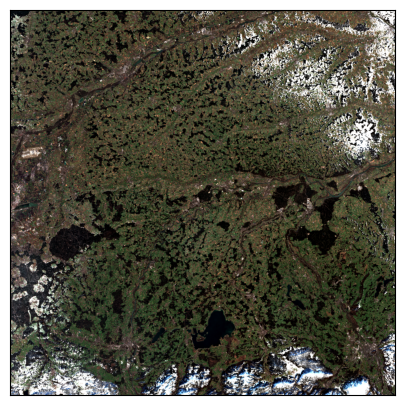

In [49]:
# Plot RGB image
# Scene 2 has no green channel/band, so RGB is not possible
rgb = ep.plot_rgb(images_array[1:4], 
                  rgb=(2,1,0), # (default = (0, 1, 2))) indices of the three RGB bands,
                  stretch=True, # apply linear stretch
                  str_clip=3.95, # pcnt of clip in linear stretch, default 2 = 2%
                  figsize=(5, 5))
plt.show()

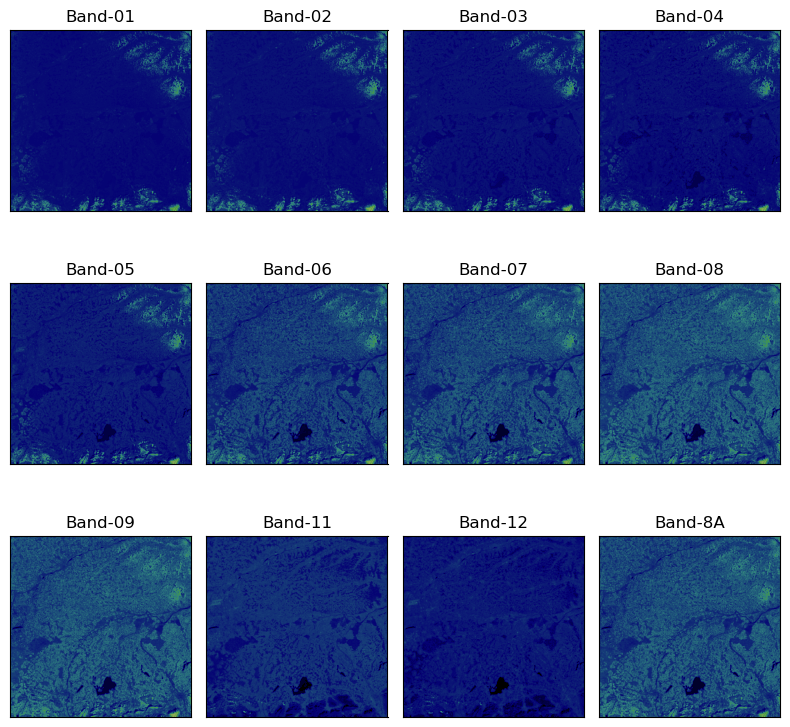

In [42]:
# Plot all bands to check for errors.
# Some bands might have low contrast, i.e., their histogram
# is expected to have a peak, due to a narrow range of intensity values.
ep.plot_bands(images_array, 
              cmap='gist_earth',
              title=[f"Band-{name}" for name in band_names],
              figsize=(8, 8),
              cols=4,
              cbar=False)
plt.show()